In [1]:
import emcee
import corner
import speclite as speclite; from speclite import filters
from tqdm import tqdm
from matplotlib import cm
from matplotlib.artist import Artist
from chromatic import *
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from specutils.spectra import Spectrum1D, SpectralRegion
from specutils.fitting import fit_generic_continuum

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
plt.style.use('tableau-colorblind10')

In [2]:
def normalized_PHOENIX(temp = 3650, w = np.linspace(300,500,100)*u.nm, **kwargs):
        
    _model = get_phoenix_photons(temperature=float(temp),wavelength = w,logg=4.4, metallicity=0.0)
    _m = _model[1]/np.nanmedian(_model[1])
    spectrum = Spectrum1D(flux=_m, spectral_axis=_model[0])
    with warnings.catch_warnings():  # Ignore warnings
        warnings.simplefilter('ignore')
        g1_fit = fit_generic_continuum(spectrum)
        continuum_fit = g1_fit(_model[0])
    normed_model = _m/continuum_fit
    
    return normed_model

In [3]:
def quick_spec_chisq(parameters, extras, **kwargs):
    
    Tspec = parameters
    rwave, rflux, runc = extras
    
    if Tspec < 2300.:
        Tspec = 2300.
    if Tspec > 7000.:
        Tspec = 7000.
    
    model = normalized_PHOENIX(temp=Tspec,w=rwave)

    chisq = np.nansum((rflux-model)**2/(runc)**2)

    return chisq

In [4]:
def clip_rainbow(rainbow,
                       order = None,
                       visit = 'define your visit in the photometry model!',
                       verbose=False,plot=False,
                       **kwargs):
    
    preclip_r = rainbow
    preclip_model = normalized_PHOENIX(temp=3650,w=preclip_r.wavelength)

    for i in tqdm(range(len(preclip_r.time))):
        
        chisq = np.nansum((preclip_r.flux[:,i]-preclip_model)**2/(preclip_r.uncertainty[:,i]**2))
        reduced_chisq = chisq/(len(preclip_r.wavelength)-1)
        err_kludge = np.sqrt(reduced_chisq)
        adjusted_preclip_err = preclip_r.uncertainty[:,i]
        if err_kludge >= 1.0:
            adjusted_preclip_err = preclip_r.uncertainty[:,i] * err_kludge
        
        if verbose:        
            print(f'clipping emission lines...')
        N_boxcar_smooth = 6 # smooth to find where we're near an emission line
        not_emission_line = ((preclip_r.flux[:,i]-preclip_model)/(adjusted_preclip_err) < 2) & (preclip_r.flux[:,i]<1.08)
        near_emission_line = np.convolve(not_emission_line == False,
                                         np.ones(N_boxcar_smooth)/N_boxcar_smooth,mode='same')
        points_to_keep = near_emission_line == False
        preclip_r.wavelike["ok"] = points_to_keep
        _r = preclip_r.trim(just_edges=False)
              
        if order == 53:
            a = _r.wavelength.value < 0.886
            _r.wavelike["ok"] = a
            __r = _r.trim(just_edges=False)
            a = __r.wavelength.value > 0.8827
            b = __r.wavelength.value < 0.8798
            __r.wavelike["ok"] = a|b
            _r = __r
        if order == 54:
            a = _r.wavelength.value > 0.859
            _r.wavelike["ok"] = a
            __r = _r.trim(just_edges=False)
            a = __r.wavelength.value < 0.8639
            b = __r.wavelength.value > 0.867
            __r.wavelike["ok"] = a|b
            _r = __r
        if order == 55:
            a = _r.wavelength.value > 0.843
            b = _r.wavelength.value < 0.8531
            _r.wavelike["ok"] = a&b
        if order == 56:
            a = _r.wavelength.value > 0.8276
            _r.wavelike["ok"] = a
        if order == 57:
            a = _r.wavelength.value < 0.8248
            b = _r.wavelength.value > 0.813
            _r.wavelike["ok"] = a&b        
        if order == 58:
            a = _r.wavelength.value < 0.8105
            b = _r.wavelength.value > 0.799
            _r.wavelike["ok"] = a&b
        if order == 60:
            a = _r.wavelength.value > 0.7728
            _r.wavelike["ok"] = a
        if order == 61:
            a = _r.wavelength.value > 0.767
            _r.wavelike["ok"] = a
        if order == 63:
            a = _r.wavelength.value > 0.7396
            b = _r.wavelength.value < 0.738
            _r.wavelike["ok"] = a|b
        if order == 65:
            a = _r.wavelength.value > 0.7134
            _r.wavelike["ok"] = a
        if order == 68:
            a = _r.wavelength.value < 0.688
            _r.wavelike["ok"] = a
        if order == 69:
            a = _r.wavelength.value > 0.6715
            b = _r.wavelength.value < 0.6819
            _r.wavelike["ok"] = a&b
        if order == 72:
            a = _r.wavelength.value < 0.6525
            _r.wavelike["ok"] = a
        if order == 73:
            a = _r.wavelength.value > 0.6406
            b = _r.wavelength.value < 0.638
            _r.wavelike["ok"] = a|b
        if order == 74:
            a = _r.wavelength.value > 0.6257
            b = _r.wavelength.value < 0.6337
            _r.wavelike["ok"] = a&b        
        if order == 75:
            a = _r.wavelength.value < 0.626
            _r.wavelike["ok"] = a
        if order == 76:
            a = _r.wavelength.value < 0.6159
            _r.wavelike["ok"] = a
        if order == 77:
            a = _r.wavelength.value < 0.61
            _r.wavelike["ok"] = a
        if order == 78:
            a = _r.wavelength.value < 0.6019
            _r.wavelike["ok"] = a
        if order == 79:
            a = _r.wavelength.value < 0.595
            b = _r.wavelength.value > 0.5861
            _r.wavelike["ok"] = a&b
            __r = _r.trim(just_edges=False)
            a = __r.wavelength.value > 0.5905
            b = __r.wavelength.value < 0.5882
            __r.wavelike["ok"] = a|b
            _r = __r
        if order == 80:
            a = _r.wavelength.value > 0.579
            b = _r.wavelength.value < 0.5875
            _r.wavelike["ok"] = a&b
        if order == 81:
            a = _r.wavelength.value > 0.5717
            b = _r.wavelength.value < 0.5799
            _r.wavelike["ok"] = a&b
        if order == 82:
            a = _r.wavelength.value > 0.5667
            b = _r.wavelength.value < 0.5732
            _r.wavelike["ok"] = a&b
        if order == 83:
            a = _r.wavelength.value > 0.5578
            b = _r.wavelength.value < 0.5663
            _r.wavelike["ok"] = a&b
        if order == 84:
            a = _r.wavelength.value > 0.552
            b = _r.wavelength.value < 0.5591
            _r.wavelike["ok"] = a&b
        
        clipped = _r.trim(just_edges=False)

        finalmodel = normalized_PHOENIX(temp=3650,w=clipped.wavelength)
        rchisq = np.nansum((clipped.flux[:,i]-finalmodel)**2/(clipped.uncertainty[:,i])**2) /(len(clipped.wavelength)-1)
        finerr_kludge = np.sqrt(rchisq)
        if finerr_kludge > 1.0: 
            clipped.uncertainty[:,i] = clipped.uncertainty[:,i]*finerr_kludge
        
        processed = clipped 

        ##########################################
        # MAKE SOME PLOTS
        ##########################################
        if plot:
            label=f'Order {order} | BJD {preclip_r.time[i]:.3f}'
            fig, axs = plt.subplots(2,2,figsize=(12,8),sharex=True)
            fig.suptitle(label,fontsize=20)

            ax1 = axs[0,0]
            ax2 = axs[1,0]
            ax3 = axs[0,1]
            ax4 = axs[1,1]

            # Upper left plot, the pre-clipped data + model
            ax1.errorbar(preclip_r.wavelength.value,preclip_r.flux[:,i],
                         yerr=preclip_r.uncertainty[:,i],color='red',alpha=0.6,zorder=-10,
                         label='Pre-clipped data',fmt='',capsize=0)
            ax1.plot(preclip_r.wavelength.value,preclip_model,color='black',zorder=100,
                     label='3600K PHOENIX model')
            ax1.set_title('Pre-clipped data with optimized model',fontsize=18)
            ax1.set_ylim(0.5,1.5)
            ax1.set_ylabel('normalized flux',fontsize=18)
            ax1.legend(loc='upper right')

            # Lower left plot, residuals on original data and model
            ax2.errorbar(preclip_r.wavelength.value,(preclip_r.flux[:,i]-preclip_model)/preclip_r.uncertainty[:,i],
                         yerr=1.0,color='black',fmt='',capsize=0,zorder=100)
            ax2.set_xlim(preclip_r.wavelength[0].value,preclip_r.wavelength[-1].value)
            ax2.set_xlabel(r'Wavelength ($\mu$m)',fontsize=18)
            ax2.set_ylabel(r'$\sigma$',fontsize=18)
            ax2.set_title('Residuals',fontsize=18)
            ax2.set_ylim(-10,10)
            ax2.axhspan(-1,1,color='red',alpha=0.2,zorder=10)
            ax2.axhspan(-2,2,color='green',alpha=0.2,zorder=0)
            ax2.axhspan(-3,3,color='gray',alpha=0.3,zorder=-10)

            # Upper right plot, the clipped data + model
            ax3.errorbar(processed.wavelength.value,processed.flux[:,i],
                         yerr=processed.uncertainty[:,i],alpha=0.7,color='teal',zorder=10,
                         label='Clipped data',fmt='',capsize=0)
            ax3.set_title('Clipped data with optimized model',fontsize=18)
            ax3.set_ylim(0.5,1.5)
            ax3.plot(processed.wavelength.value,finalmodel,color='black',zorder=100,
                     label='3600 K PHOENIX model')
            ax3.legend(loc='upper right')

            # Lower right plot, the final residuals
            ax4.errorbar(processed.wavelength.value,
                     (processed.flux[:,i]-finalmodel)/processed.uncertainty[:,i],
                     yerr=1.0,color='black',fmt='',capsize=0,zorder=100)
            ax4.set_ylim(-5,5)
            ax4.set_ylabel(r'$\sigma$',fontsize=18)
            ax4.set_xlim(preclip_r.wavelength[0].value,preclip_r.wavelength[-1].value)
            ax4.set_xlabel(r'Wavelength ($\mu$m)',fontsize=18)
            ax4.set_title('Residuals',fontsize=18)
            ax4.axhspan(-1,1,color='red',alpha=0.2,zorder=10)
            ax4.axhspan(-2,2,color='green',alpha=0.2,zorder=0)
            ax4.axhspan(-3,3,color='gray',alpha=0.3,zorder=-10)
            plt.savefig(f'../figs/diagnostics/sigmaclip_nres/{visit}_{order}_{i}_sigmaclipped.png',dpi=100)
            plt.close()

    return processed

In [7]:
transmission_data = np.loadtxt('../data/transmission_comp.txt')
mol_wave = transmission_data[:,0]*(1e-3) * u.micron
mol_data = transmission_data[:,1]
plot = True

for visit in ['F21','S22']:

    if visit == 'F21':
        _edges = np.array([2459451.0,2459452.0,2459454.0,2459457.0,
                           2459459.0,2459460.0,2459463.0,2459467.0])*u.day
        T0 = np.array([2459455.98]) * u.day
        velocity = -9.5 * u.km/u.s
    if visit == 'S22':
        _edges = np.array([2459671.5,2459672.5,2459673.5,2459674.5,2459675.5,
                          2459676.5,2459677.5,2459678.5,2459679.5,
                          2459680.5,2459681.5,2459682.5,2459683.5,2459684.5,
                          2459685.5,2459686.5,2459687.5,2459688.5])*u.day
        T0 = np.array([2459684.40]) * u.day
        velocity = 33.0 * u.km/u.s
        
    for order in tqdm(np.arange(53,85)):

        init_rainbow = Rainbow(f'../data/NRES/{visit}_spectra/*e92-1d*', format='nres', order=order)
        init_rainbow.save(f'../data/rainbows/{visit}_{order}_original.rainbow.npy')
        shifted = init_rainbow.align_wavelengths().shift(velocity).bin(dw=0.05*u.nm,time_edges = _edges,
                                                                        ntimes=len(_edges),
                                                                        minimum_points_per_bin=1)
        xlims = [shifted.wavelength.value[0],shifted.wavelength.value[-1]]
        shifted.save(f"../data/rainbows/{visit}_{order}_shifted.rainbow.npy")
        "Telluric Correction"
        this_orders_tellurics = bintogrid(mol_wave.value,mol_data,newx=shifted.wavelength.value,visualize=False)
        transparent_wavelengths = (this_orders_tellurics['y'] > 0.995)
        shifted.wavelike["ok"] = transparent_wavelengths
        tellcor = shifted.trim(just_edges=False)
        tellcor.save(f"../data/rainbows/{visit}_{order}_tellcorr.rainbow.npy")
        "Trim order-specific regions and emission lines"
        _clipped = clip_rainbow(rainbow=tellcor,order=order,visit=visit,plot=plot)
        clipped = _clipped.trim(just_edges = False)
        clipped.flux[clipped.ok == False] = np.nan
        clipped.save(f"../data/rainbows/{visit}_{order}_clipped.rainbow.npy")
        "Calculate and save an average flux rainbow"
        avg_flux = clipped.get_average_spectrum()
        avg_err = np.nanmedian(clipped.uncertainty,axis=1)/(len(_edges)-1)
        template_spec = normalized_PHOENIX(temp=3650,w=clipped.wavelength)
        rchisq = np.nansum((template_spec-avg_flux)**2/(avg_err)**2) / (len(avg_flux)-1) 
        if rchisq > 1.0:
            avg_err = avg_err * np.sqrt(rchisq)
        
        if plot:        
            plt.figure()
            plt.title(f'{visit} time-averaged NRES spectrum | Order {order}')
            plt.errorbar(clipped.wavelength,avg_flux,yerr=avg_err,label='Processed time-avg NRES spectrum',alpha=0.5)
            plt.plot(clipped.wavelength,template_spec,label='3600 K PHOENIX model',alpha=1,color='k',zorder=-1)
            plt.plot()
            plt.ylim(0.25,1.2)
            plt.xlim(xlims[0],xlims[1])
            plt.legend(loc='lower left',fontsize=12)
            plt.savefig(f'../figs/diagnostics/{visit}_order{order}_processed_spec.png')
            plt.close()

  0%|          | 0/32 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3560 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3567 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3569 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3649 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3636 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3580 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3575 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3570 [00:00<?, ?it/s]

🌈🤖 It looks like you're trying to bin in wavelength for a
`Rainbow` object that might not be normalized. In the
current version of `chromatic`, binning before normalizing
might give inaccurate results if the typical uncertainty
varies strongly with wavelength.

Please consider normalizing first, for example with
`rainbow.normalize().bin(...)`
so that all uncertainties will effectively be relative,
and the inverse variance weighting used for binning
wavelengths together will give more reasonable answers.

If you really need to bin before normalizing, please submit
an Issue at github.com/zkbt/chromatic/, and we'll try to
prioritize implementing a statistically sound solution as
soon as possible!



  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/4070 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3569 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3628 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3777 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3462 [00:00<?, ?it/s]

🌈🤖 It looks like you're trying to bin in wavelength for a
`Rainbow` object that might not be normalized. In the
current version of `chromatic`, binning before normalizing
might give inaccurate results if the typical uncertainty
varies strongly with wavelength.

Please consider normalizing first, for example with
`rainbow.normalize().bin(...)`
so that all uncertainties will effectively be relative,
and the inverse variance weighting used for binning
wavelengths together will give more reasonable answers.

If you really need to bin before normalizing, please submit
an Issue at github.com/zkbt/chromatic/, and we'll try to
prioritize implementing a statistically sound solution as
soon as possible!



  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3637 [00:00<?, ?it/s]

🌈🤖 It looks like you're trying to bin in wavelength for a
`Rainbow` object that might not be normalized. In the
current version of `chromatic`, binning before normalizing
might give inaccurate results if the typical uncertainty
varies strongly with wavelength.

Please consider normalizing first, for example with
`rainbow.normalize().bin(...)`
so that all uncertainties will effectively be relative,
and the inverse variance weighting used for binning
wavelengths together will give more reasonable answers.

If you really need to bin before normalizing, please submit
an Issue at github.com/zkbt/chromatic/, and we'll try to
prioritize implementing a statistically sound solution as
soon as possible!



  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3575 [00:00<?, ?it/s]

🌈🤖 It looks like you're trying to bin in wavelength for a
`Rainbow` object that might not be normalized. In the
current version of `chromatic`, binning before normalizing
might give inaccurate results if the typical uncertainty
varies strongly with wavelength.

Please consider normalizing first, for example with
`rainbow.normalize().bin(...)`
so that all uncertainties will effectively be relative,
and the inverse variance weighting used for binning
wavelengths together will give more reasonable answers.

If you really need to bin before normalizing, please submit
an Issue at github.com/zkbt/chromatic/, and we'll try to
prioritize implementing a statistically sound solution as
soon as possible!



  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3343 [00:00<?, ?it/s]

🌈🤖 It looks like you're trying to bin in wavelength for a
`Rainbow` object that might not be normalized. In the
current version of `chromatic`, binning before normalizing
might give inaccurate results if the typical uncertainty
varies strongly with wavelength.

Please consider normalizing first, for example with
`rainbow.normalize().bin(...)`
so that all uncertainties will effectively be relative,
and the inverse variance weighting used for binning
wavelengths together will give more reasonable answers.

If you really need to bin before normalizing, please submit
an Issue at github.com/zkbt/chromatic/, and we'll try to
prioritize implementing a statistically sound solution as
soon as possible!



  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3567 [00:00<?, ?it/s]

🌈🤖 It looks like you're trying to bin in wavelength for a
`Rainbow` object that might not be normalized. In the
current version of `chromatic`, binning before normalizing
might give inaccurate results if the typical uncertainty
varies strongly with wavelength.

Please consider normalizing first, for example with
`rainbow.normalize().bin(...)`
so that all uncertainties will effectively be relative,
and the inverse variance weighting used for binning
wavelengths together will give more reasonable answers.

If you really need to bin before normalizing, please submit
an Issue at github.com/zkbt/chromatic/, and we'll try to
prioritize implementing a statistically sound solution as
soon as possible!



  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3568 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3607 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3550 [00:00<?, ?it/s]

🌈🤖 It looks like you're trying to bin in wavelength for a
`Rainbow` object that might not be normalized. In the
current version of `chromatic`, binning before normalizing
might give inaccurate results if the typical uncertainty
varies strongly with wavelength.

Please consider normalizing first, for example with
`rainbow.normalize().bin(...)`
so that all uncertainties will effectively be relative,
and the inverse variance weighting used for binning
wavelengths together will give more reasonable answers.

If you really need to bin before normalizing, please submit
an Issue at github.com/zkbt/chromatic/, and we'll try to
prioritize implementing a statistically sound solution as
soon as possible!



  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3568 [00:00<?, ?it/s]

🌈🤖 It looks like you're trying to bin in wavelength for a
`Rainbow` object that might not be normalized. In the
current version of `chromatic`, binning before normalizing
might give inaccurate results if the typical uncertainty
varies strongly with wavelength.

Please consider normalizing first, for example with
`rainbow.normalize().bin(...)`
so that all uncertainties will effectively be relative,
and the inverse variance weighting used for binning
wavelengths together will give more reasonable answers.

If you really need to bin before normalizing, please submit
an Issue at github.com/zkbt/chromatic/, and we'll try to
prioritize implementing a statistically sound solution as
soon as possible!



  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3646 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3568 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3569 [00:00<?, ?it/s]

🌈🤖 It looks like you're trying to bin in wavelength for a
`Rainbow` object that might not be normalized. In the
current version of `chromatic`, binning before normalizing
might give inaccurate results if the typical uncertainty
varies strongly with wavelength.

Please consider normalizing first, for example with
`rainbow.normalize().bin(...)`
so that all uncertainties will effectively be relative,
and the inverse variance weighting used for binning
wavelengths together will give more reasonable answers.

If you really need to bin before normalizing, please submit
an Issue at github.com/zkbt/chromatic/, and we'll try to
prioritize implementing a statistically sound solution as
soon as possible!



  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3568 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3625 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3529 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3570 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3568 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3570 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3569 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3573 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/3555 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/3568 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/3567 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/3651 [00:00<?, ?it/s]

🌈🤖 It looks like you're trying to bin in wavelength for a
`Rainbow` object that might not be normalized. In the
current version of `chromatic`, binning before normalizing
might give inaccurate results if the typical uncertainty
varies strongly with wavelength.

Please consider normalizing first, for example with
`rainbow.normalize().bin(...)`
so that all uncertainties will effectively be relative,
and the inverse variance weighting used for binning
wavelengths together will give more reasonable answers.

If you really need to bin before normalizing, please submit
an Issue at github.com/zkbt/chromatic/, and we'll try to
prioritize implementing a statistically sound solution as
soon as possible!



  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/3663 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/3577 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/3574 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/3568 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/4066 [00:00<?, ?it/s]

🌈🤖 It looks like you're trying to bin in wavelength for a
`Rainbow` object that might not be normalized. In the
current version of `chromatic`, binning before normalizing
might give inaccurate results if the typical uncertainty
varies strongly with wavelength.

Please consider normalizing first, for example with
`rainbow.normalize().bin(...)`
so that all uncertainties will effectively be relative,
and the inverse variance weighting used for binning
wavelengths together will give more reasonable answers.

If you really need to bin before normalizing, please submit
an Issue at github.com/zkbt/chromatic/, and we'll try to
prioritize implementing a statistically sound solution as
soon as possible!



  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/3568 [00:00<?, ?it/s]

🌈🤖 It looks like you're trying to bin in wavelength for a
`Rainbow` object that might not be normalized. In the
current version of `chromatic`, binning before normalizing
might give inaccurate results if the typical uncertainty
varies strongly with wavelength.

Please consider normalizing first, for example with
`rainbow.normalize().bin(...)`
so that all uncertainties will effectively be relative,
and the inverse variance weighting used for binning
wavelengths together will give more reasonable answers.

If you really need to bin before normalizing, please submit
an Issue at github.com/zkbt/chromatic/, and we'll try to
prioritize implementing a statistically sound solution as
soon as possible!



  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/3628 [00:00<?, ?it/s]

🌈🤖 It looks like you're trying to bin in wavelength for a
`Rainbow` object that might not be normalized. In the
current version of `chromatic`, binning before normalizing
might give inaccurate results if the typical uncertainty
varies strongly with wavelength.

Please consider normalizing first, for example with
`rainbow.normalize().bin(...)`
so that all uncertainties will effectively be relative,
and the inverse variance weighting used for binning
wavelengths together will give more reasonable answers.

If you really need to bin before normalizing, please submit
an Issue at github.com/zkbt/chromatic/, and we'll try to
prioritize implementing a statistically sound solution as
soon as possible!



  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/3772 [00:00<?, ?it/s]

🌈🤖 It looks like you're trying to bin in wavelength for a
`Rainbow` object that might not be normalized. In the
current version of `chromatic`, binning before normalizing
might give inaccurate results if the typical uncertainty
varies strongly with wavelength.

Please consider normalizing first, for example with
`rainbow.normalize().bin(...)`
so that all uncertainties will effectively be relative,
and the inverse variance weighting used for binning
wavelengths together will give more reasonable answers.

If you really need to bin before normalizing, please submit
an Issue at github.com/zkbt/chromatic/, and we'll try to
prioritize implementing a statistically sound solution as
soon as possible!



  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/3457 [00:00<?, ?it/s]

🌈🤖 It looks like you're trying to bin in wavelength for a
`Rainbow` object that might not be normalized. In the
current version of `chromatic`, binning before normalizing
might give inaccurate results if the typical uncertainty
varies strongly with wavelength.

Please consider normalizing first, for example with
`rainbow.normalize().bin(...)`
so that all uncertainties will effectively be relative,
and the inverse variance weighting used for binning
wavelengths together will give more reasonable answers.

If you really need to bin before normalizing, please submit
an Issue at github.com/zkbt/chromatic/, and we'll try to
prioritize implementing a statistically sound solution as
soon as possible!



  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/3636 [00:00<?, ?it/s]

🌈🤖 It looks like you're trying to bin in wavelength for a
`Rainbow` object that might not be normalized. In the
current version of `chromatic`, binning before normalizing
might give inaccurate results if the typical uncertainty
varies strongly with wavelength.

Please consider normalizing first, for example with
`rainbow.normalize().bin(...)`
so that all uncertainties will effectively be relative,
and the inverse variance weighting used for binning
wavelengths together will give more reasonable answers.

If you really need to bin before normalizing, please submit
an Issue at github.com/zkbt/chromatic/, and we'll try to
prioritize implementing a statistically sound solution as
soon as possible!



  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/3586 [00:00<?, ?it/s]

🌈🤖 It looks like you're trying to bin in wavelength for a
`Rainbow` object that might not be normalized. In the
current version of `chromatic`, binning before normalizing
might give inaccurate results if the typical uncertainty
varies strongly with wavelength.

Please consider normalizing first, for example with
`rainbow.normalize().bin(...)`
so that all uncertainties will effectively be relative,
and the inverse variance weighting used for binning
wavelengths together will give more reasonable answers.

If you really need to bin before normalizing, please submit
an Issue at github.com/zkbt/chromatic/, and we'll try to
prioritize implementing a statistically sound solution as
soon as possible!



  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/3341 [00:00<?, ?it/s]

🌈🤖 It looks like you're trying to bin in wavelength for a
`Rainbow` object that might not be normalized. In the
current version of `chromatic`, binning before normalizing
might give inaccurate results if the typical uncertainty
varies strongly with wavelength.

Please consider normalizing first, for example with
`rainbow.normalize().bin(...)`
so that all uncertainties will effectively be relative,
and the inverse variance weighting used for binning
wavelengths together will give more reasonable answers.

If you really need to bin before normalizing, please submit
an Issue at github.com/zkbt/chromatic/, and we'll try to
prioritize implementing a statistically sound solution as
soon as possible!



  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/3568 [00:00<?, ?it/s]

🌈🤖 It looks like you're trying to bin in wavelength for a
`Rainbow` object that might not be normalized. In the
current version of `chromatic`, binning before normalizing
might give inaccurate results if the typical uncertainty
varies strongly with wavelength.

Please consider normalizing first, for example with
`rainbow.normalize().bin(...)`
so that all uncertainties will effectively be relative,
and the inverse variance weighting used for binning
wavelengths together will give more reasonable answers.

If you really need to bin before normalizing, please submit
an Issue at github.com/zkbt/chromatic/, and we'll try to
prioritize implementing a statistically sound solution as
soon as possible!



  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/3568 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/3604 [00:00<?, ?it/s]

🌈🤖 It looks like you're trying to bin in wavelength for a
`Rainbow` object that might not be normalized. In the
current version of `chromatic`, binning before normalizing
might give inaccurate results if the typical uncertainty
varies strongly with wavelength.

Please consider normalizing first, for example with
`rainbow.normalize().bin(...)`
so that all uncertainties will effectively be relative,
and the inverse variance weighting used for binning
wavelengths together will give more reasonable answers.

If you really need to bin before normalizing, please submit
an Issue at github.com/zkbt/chromatic/, and we'll try to
prioritize implementing a statistically sound solution as
soon as possible!



  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/3550 [00:00<?, ?it/s]

🌈🤖 It looks like you're trying to bin in wavelength for a
`Rainbow` object that might not be normalized. In the
current version of `chromatic`, binning before normalizing
might give inaccurate results if the typical uncertainty
varies strongly with wavelength.

Please consider normalizing first, for example with
`rainbow.normalize().bin(...)`
so that all uncertainties will effectively be relative,
and the inverse variance weighting used for binning
wavelengths together will give more reasonable answers.

If you really need to bin before normalizing, please submit
an Issue at github.com/zkbt/chromatic/, and we'll try to
prioritize implementing a statistically sound solution as
soon as possible!



  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/3568 [00:00<?, ?it/s]

🌈🤖 It looks like you're trying to bin in wavelength for a
`Rainbow` object that might not be normalized. In the
current version of `chromatic`, binning before normalizing
might give inaccurate results if the typical uncertainty
varies strongly with wavelength.

Please consider normalizing first, for example with
`rainbow.normalize().bin(...)`
so that all uncertainties will effectively be relative,
and the inverse variance weighting used for binning
wavelengths together will give more reasonable answers.

If you really need to bin before normalizing, please submit
an Issue at github.com/zkbt/chromatic/, and we'll try to
prioritize implementing a statistically sound solution as
soon as possible!



  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/3645 [00:00<?, ?it/s]

🌈🤖 It looks like you're trying to bin in wavelength for a
`Rainbow` object that might not be normalized. In the
current version of `chromatic`, binning before normalizing
might give inaccurate results if the typical uncertainty
varies strongly with wavelength.

Please consider normalizing first, for example with
`rainbow.normalize().bin(...)`
so that all uncertainties will effectively be relative,
and the inverse variance weighting used for binning
wavelengths together will give more reasonable answers.

If you really need to bin before normalizing, please submit
an Issue at github.com/zkbt/chromatic/, and we'll try to
prioritize implementing a statistically sound solution as
soon as possible!



  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/3568 [00:00<?, ?it/s]

🌈🤖 It looks like you're trying to bin in wavelength for a
`Rainbow` object that might not be normalized. In the
current version of `chromatic`, binning before normalizing
might give inaccurate results if the typical uncertainty
varies strongly with wavelength.

Please consider normalizing first, for example with
`rainbow.normalize().bin(...)`
so that all uncertainties will effectively be relative,
and the inverse variance weighting used for binning
wavelengths together will give more reasonable answers.

If you really need to bin before normalizing, please submit
an Issue at github.com/zkbt/chromatic/, and we'll try to
prioritize implementing a statistically sound solution as
soon as possible!



  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/3568 [00:00<?, ?it/s]

🌈🤖 It looks like you're trying to bin in wavelength for a
`Rainbow` object that might not be normalized. In the
current version of `chromatic`, binning before normalizing
might give inaccurate results if the typical uncertainty
varies strongly with wavelength.

Please consider normalizing first, for example with
`rainbow.normalize().bin(...)`
so that all uncertainties will effectively be relative,
and the inverse variance weighting used for binning
wavelengths together will give more reasonable answers.

If you really need to bin before normalizing, please submit
an Issue at github.com/zkbt/chromatic/, and we'll try to
prioritize implementing a statistically sound solution as
soon as possible!



  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/3569 [00:00<?, ?it/s]

🌈🤖 It looks like you're trying to bin in wavelength for a
`Rainbow` object that might not be normalized. In the
current version of `chromatic`, binning before normalizing
might give inaccurate results if the typical uncertainty
varies strongly with wavelength.

Please consider normalizing first, for example with
`rainbow.normalize().bin(...)`
so that all uncertainties will effectively be relative,
and the inverse variance weighting used for binning
wavelengths together will give more reasonable answers.

If you really need to bin before normalizing, please submit
an Issue at github.com/zkbt/chromatic/, and we'll try to
prioritize implementing a statistically sound solution as
soon as possible!



  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/3625 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/3529 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/3569 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

0it [00:00, ?it/s]

🌈🤖 The 4096 input wavelengths were not monotonically increasing.
<🌈(4096w, 47t)> has been sorted from lowest to highest wavelength.
If you want to recover the original wavelength order, the original
wavelength indices are available in `rainbow.original_wave_index`.



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/3569 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

0it [00:00, ?it/s]

🌈🤖 The 4096 input wavelengths were not monotonically increasing.
<🌈(4096w, 47t)> has been sorted from lowest to highest wavelength.
If you want to recover the original wavelength order, the original
wavelength indices are available in `rainbow.original_wave_index`.



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/3569 [00:00<?, ?it/s]

🌈🤖 It looks like you're trying to bin in wavelength for a
`Rainbow` object that might not be normalized. In the
current version of `chromatic`, binning before normalizing
might give inaccurate results if the typical uncertainty
varies strongly with wavelength.

Please consider normalizing first, for example with
`rainbow.normalize().bin(...)`
so that all uncertainties will effectively be relative,
and the inverse variance weighting used for binning
wavelengths together will give more reasonable answers.

If you really need to bin before normalizing, please submit
an Issue at github.com/zkbt/chromatic/, and we'll try to
prioritize implementing a statistically sound solution as
soon as possible!



  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

0it [00:00, ?it/s]

🌈🤖 The 4096 input wavelengths were not monotonically increasing.
<🌈(4096w, 47t)> has been sorted from lowest to highest wavelength.
If you want to recover the original wavelength order, the original
wavelength indices are available in `rainbow.original_wave_index`.



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/3569 [00:00<?, ?it/s]

🌈🤖 It looks like you're trying to bin in wavelength for a
`Rainbow` object that might not be normalized. In the
current version of `chromatic`, binning before normalizing
might give inaccurate results if the typical uncertainty
varies strongly with wavelength.

Please consider normalizing first, for example with
`rainbow.normalize().bin(...)`
so that all uncertainties will effectively be relative,
and the inverse variance weighting used for binning
wavelengths together will give more reasonable answers.

If you really need to bin before normalizing, please submit
an Issue at github.com/zkbt/chromatic/, and we'll try to
prioritize implementing a statistically sound solution as
soon as possible!



  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

0it [00:00, ?it/s]

🌈🤖 The 4096 input wavelengths were not monotonically increasing.
<🌈(4096w, 47t)> has been sorted from lowest to highest wavelength.
If you want to recover the original wavelength order, the original
wavelength indices are available in `rainbow.original_wave_index`.



  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/3569 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

In [8]:
all_orders = np.arange(53,84)
F21best_vshift = [None]*len(all_orders)
S22best_vshift = [None]*len(all_orders)
F21best_Teff = [None]*len(all_orders)
S22best_Teff = [None]*len(all_orders)
Teff_array = np.arange(3000,8050,50)
vshift_array = np.arange(-8,8,0.5)

In [9]:
j = 0
for order in tqdm(all_orders):
    F21_vshift_rchisq_array = np.ones_like(vshift_array)
    S22_vshift_rchisq_array = np.ones_like(vshift_array)
    F21_Teff_rchisq_array = np.ones_like(Teff_array)
    S22_Teff_rchisq_array = np.ones_like(Teff_array)

    _r = read_rainbow(f"../data/rainbows/F21_{order}_shifted.rainbow.npy")
    this_F21_r = read_rainbow(f"../data/rainbows/F21_{order}_clipped.rainbow.npy")
    #correct the error bars for an initial best-fit chi^2#
    F21_rainbow = this_F21_r
    F21_avg_flux = this_F21_r.get_average_spectrum()
    F21_avg_err = np.nanmedian(this_F21_r.uncertainty,axis=1)
    template_spec = normalized_PHOENIX(temp=3650,w=this_F21_r.wavelength)
    rchisq = np.nansum((template_spec-F21_avg_flux)**2/(F21_avg_err)**2) / (len(F21_avg_flux)-1) 
    if rchisq > 1.0:
        F21_rainbow.uncertainty = this_F21_r.uncertainty * np.sqrt(rchisq)
    this_S22_r = read_rainbow(f"../data/rainbows/S22_{order}_clipped.rainbow.npy")
    S22_rainbow = this_S22_r
    S22_avg_flux = this_S22_r.get_average_spectrum()
    S22_avg_err = np.nanmedian(this_S22_r.uncertainty,axis=1)
    template_spec = normalized_PHOENIX(temp=3650,w=this_S22_r.wavelength)
    rchisq = np.nansum((template_spec-S22_avg_flux)**2/(S22_avg_err)**2) / (len(S22_avg_flux)-1) 
    if rchisq > 1.0:
        S22_rainbow.uncertainty = this_S22_r.uncertainty * np.sqrt(rchisq)    
    # Loop through the vshift array, shifting the data, calculating a model, and calculating a reduced chisq
    i = 0
    for shift in vshift_array:
        reshifted = F21_rainbow.shift(shift * u.km/u.s)
        _f = reshifted.get_average_spectrum()
        _e = np.nanmedian(reshifted.uncertainty,axis=1)
        _m = normalized_PHOENIX(temp=3650,w=reshifted.wavelength)
        rchisq = np.nansum((_m-_f)**2/(_e)**2) / (len(_f)-1)
        F21_vshift_rchisq_array[i] = rchisq

        reshifted = S22_rainbow.shift(shift * u.km/u.s)
        _f = reshifted.get_average_spectrum()
        _e = np.nanmedian(reshifted.uncertainty,axis=1)
        _m = normalized_PHOENIX(temp=3650,w=reshifted.wavelength)
        rchisq = np.nansum((_m-_f)**2/(_e)**2) / (len(_f)-1) 
        S22_vshift_rchisq_array[i] = rchisq
        i+=1
    
    i = 0
    for Teff in Teff_array:
        _m = normalized_PHOENIX(temp=Teff,w=F21_rainbow.wavelength)
        rchisq = np.nansum((_m-F21_avg_flux)**2/(F21_avg_err)**2) / (len(F21_avg_flux)-1)
        F21_Teff_rchisq_array[i] = rchisq

        _m = normalized_PHOENIX(temp=Teff,w=S22_rainbow.wavelength)
        rchisq = np.nansum((_m-S22_avg_flux)**2/(S22_avg_err)**2) / (len(S22_avg_flux)-1)
        S22_Teff_rchisq_array[i] = rchisq
        i+=1
        
    F21best_vshift[j] = vshift_array[np.where(F21_vshift_rchisq_array == np.nanmin(F21_vshift_rchisq_array))][0]
    S22best_vshift[j] = vshift_array[np.where(S22_vshift_rchisq_array == np.nanmin(S22_vshift_rchisq_array))][0]
    
    F21best_Teff[j] = Teff_array[np.where(F21_Teff_rchisq_array == np.nanmin(F21_Teff_rchisq_array))][0]
    S22best_Teff[j] = Teff_array[np.where(S22_Teff_rchisq_array == np.nanmin(S22_Teff_rchisq_array))][0]

    fig,axs = plt.subplots(2,2,figsize=(10,8))
    fig.suptitle(f'Order {order} '+r'$\chi^2$ diagnostics',fontsize='xx-large')
    axs[0,0].set_title(f'F21 v shift relative to -10 km/s with a T=3600K model')
    axs[0,0].axvline(F21best_vshift[j])
    axs[0,0].scatter(vshift_array,F21_vshift_rchisq_array)
    axs[0,0].set_xlabel('Velocity shift (km/s)')
    axs[0,0].set_ylabel(r'Reduced $\chi^2$')
    axs[0,0].set_ylim(1,)  
    axs[0,0].set_yscale('log')

    axs[1,0].set_title(f'F21 Teff')
    axs[1,0].scatter(Teff_array,F21_Teff_rchisq_array)
    axs[1,0].axvline(F21best_Teff[j],label=f'{int(F21best_Teff[j])} K')
    axs[1,0].set_xlabel('Teff (K)')
    axs[1,0].set_ylabel(r'Reduced $\chi^2$')
    axs[1,0].legend(loc='upper right')
    axs[1,0].set_ylim(1,)
    axs[1,0].set_yscale('log')

    axs[0,1].set_title(f'S22 v shift relative to 33 km/s with a T=3600K model')
    axs[0,1].axvline(S22best_vshift[j])
    axs[0,1].scatter(vshift_array,S22_vshift_rchisq_array)
    axs[0,1].set_xlabel('Velocity shift (km/s)')
    axs[0,1].set_ylabel(r'Reduced $\chi^2$')
    axs[0,1].set_ylim(1,)
    axs[0,1].set_yscale('log')

    axs[1,1].set_title(f'S22 Teff')
    axs[1,1].scatter(Teff_array,S22_Teff_rchisq_array)
    axs[1,1].axvline(S22best_Teff[j],label=f'{int(S22best_Teff[j])} K')
    axs[1,1].set_xlabel('Teff (K)')
    axs[1,1].set_ylabel(r'Reduced $\chi^2$')
    axs[1,1].legend(loc='upper right')
    axs[1,1].set_ylim(1,) 
    axs[1,1].set_yscale('log')

    plt.savefig(f'../figs/diagnostics/order{order}_chisqplots.png',dpi=100)
    plt.close()

    j += 1

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/187 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

  0%|          | 0/167 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/222 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/229 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/165 [00:00<?, ?it/s]

  0%|          | 0/175 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/191 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/95 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/153 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/107 [00:00<?, ?it/s]

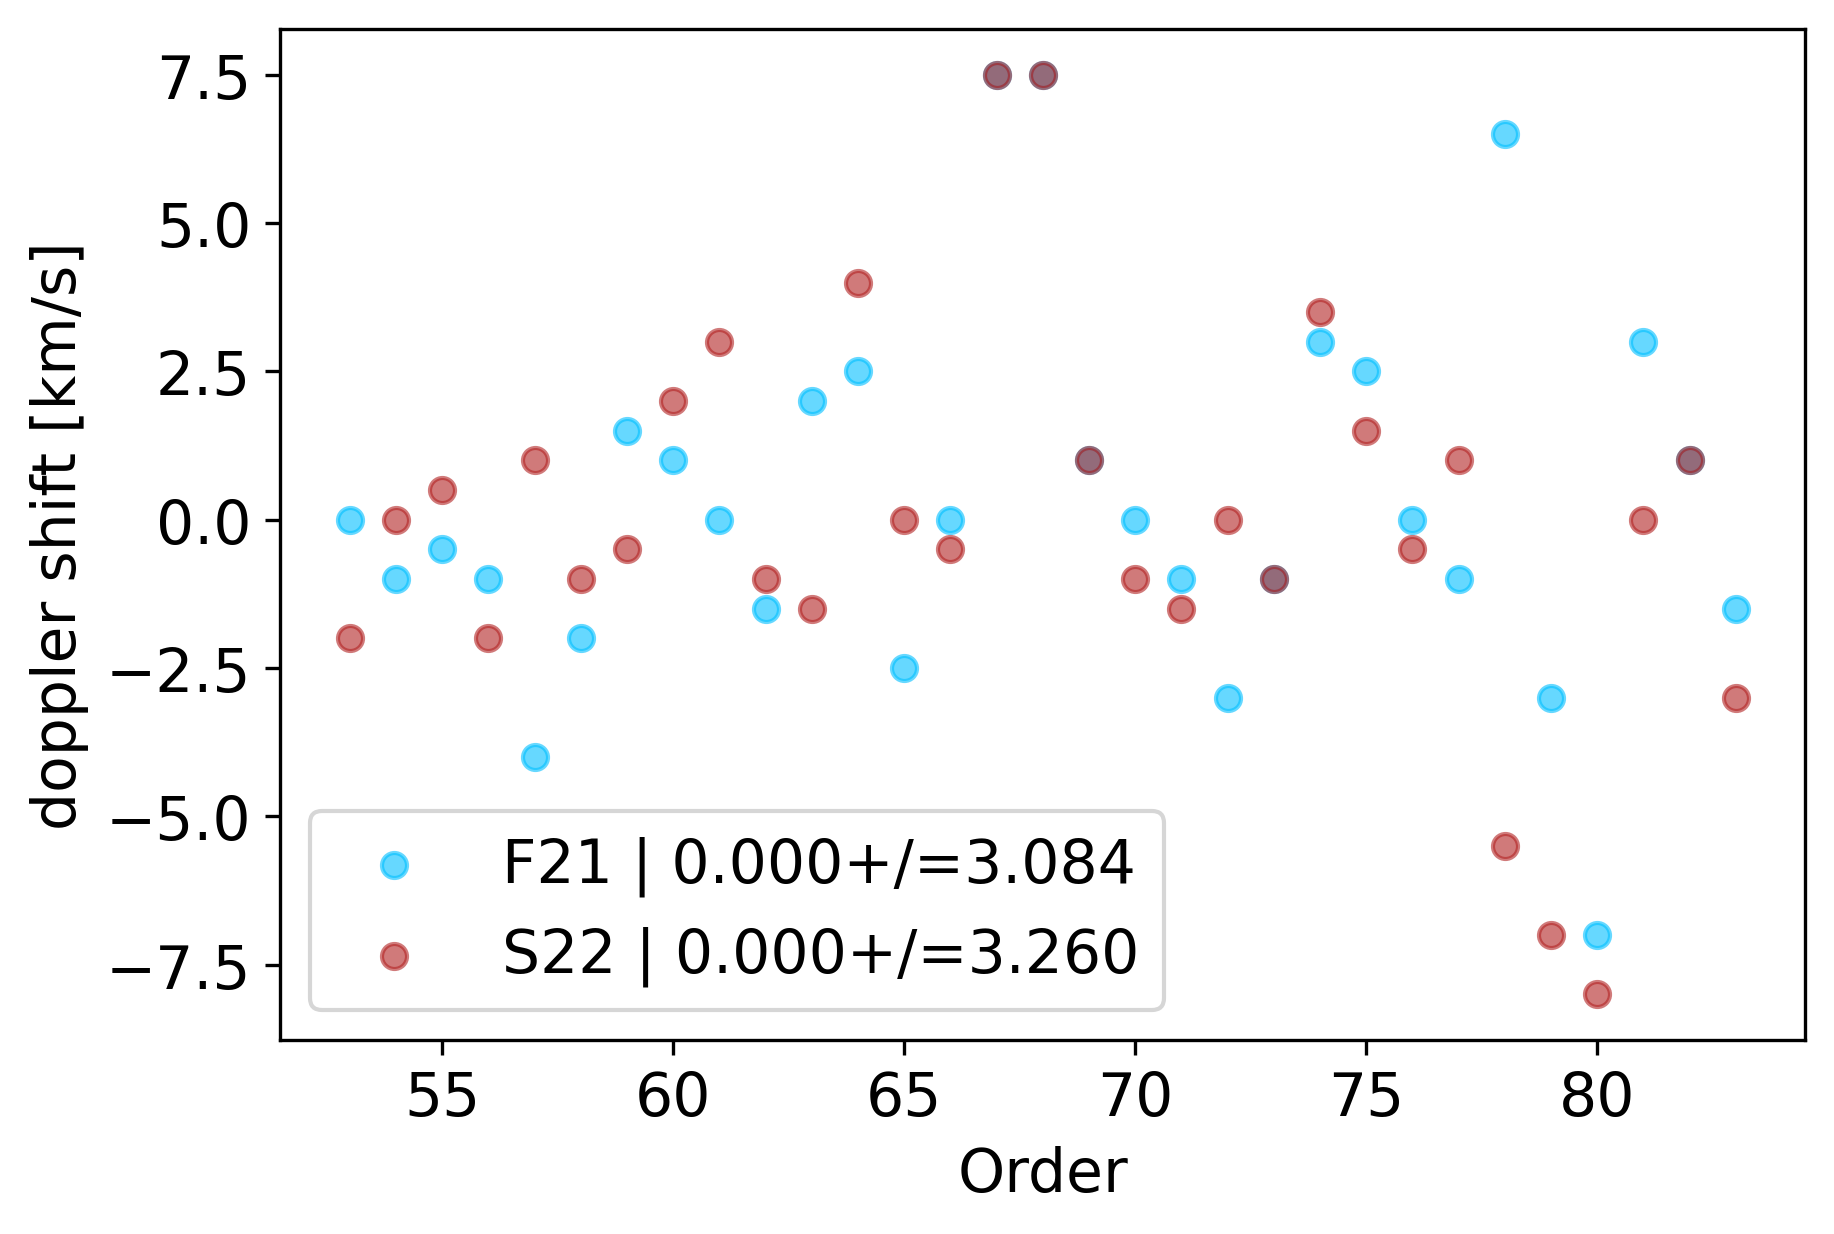

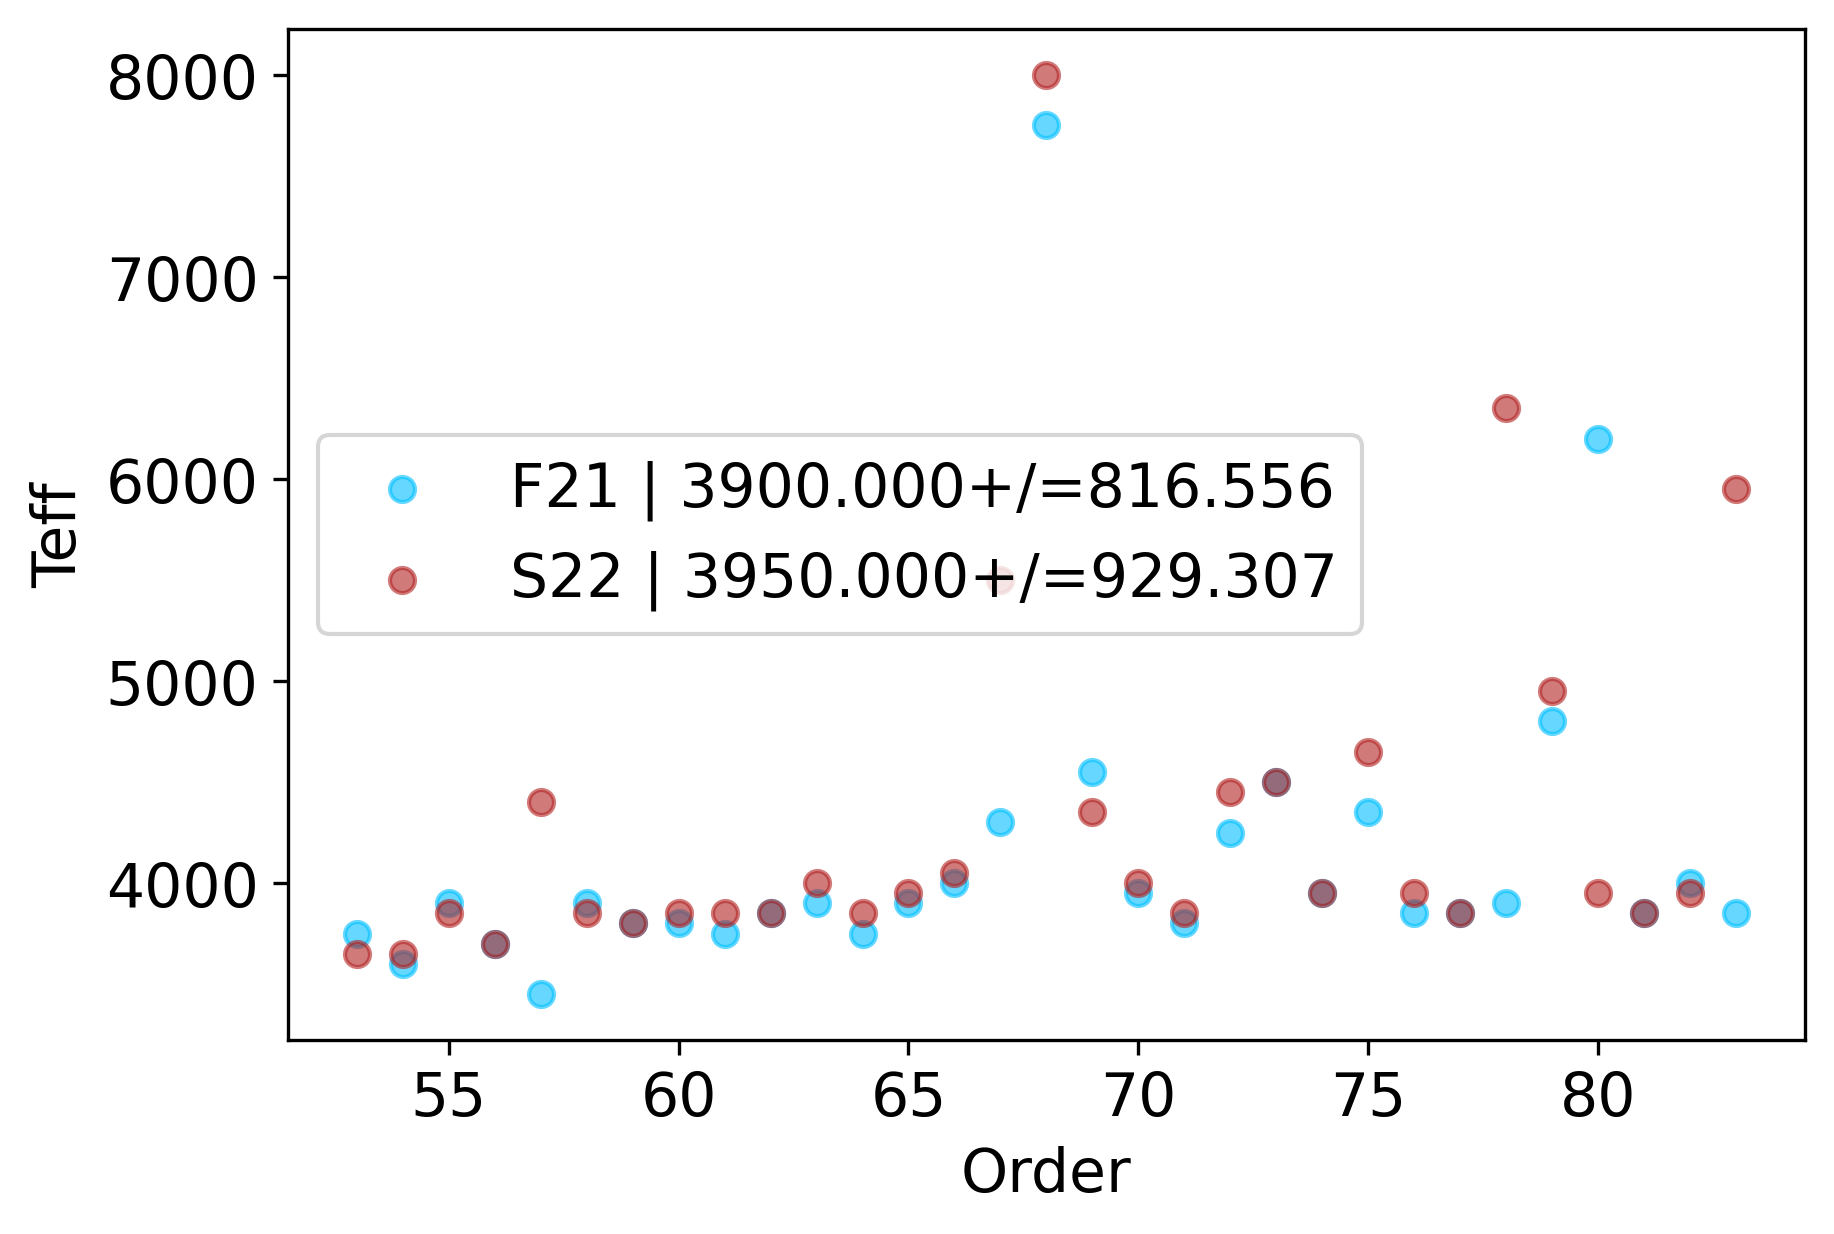

In [10]:
plt.figure()
plt.scatter(all_orders,F21best_vshift,label=f'F21 | {np.median(F21best_vshift):.3f}+/={np.std(F21best_vshift):.3f}',color='deepskyblue',alpha=0.6)
plt.scatter(all_orders,S22best_vshift,label=f'S22 | {np.median(S22best_vshift):.3f}+/={np.std(S22best_vshift):.3f}',color='firebrick',alpha=0.6)
plt.xlabel('Order')
plt.ylabel('doppler shift [km/s]')
plt.legend()
plt.savefig('../figs/Feb13_vshift_vs_order.png')

plt.figure()
plt.scatter(all_orders,F21best_Teff,label=f'F21 | {np.median(F21best_Teff):.3f}+/={np.std(F21best_Teff):.3f}',color='deepskyblue',alpha=0.6)
plt.scatter(all_orders,S22best_Teff,label=f'S22 | {np.median(S22best_Teff):.3f}+/={np.std(S22best_Teff):.3f}',color='firebrick',alpha=0.6)
plt.xlabel('Order')
plt.ylabel('Teff')
plt.legend()
plt.savefig('../figs/Feb13_Teff_vs_order.png')